In [1]:
from __future__ import print_function, division
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import string
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode


In [2]:
train_one_dir = './train1/'
train_two_dir = './train2/'
test_dir = './test/'

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std  = np.array([0.229, 0.224, 0.225])

In [3]:
def splitUnderline(landmarks):
    """ 将下划线去除 
    传入值：landmarks_frame_train_one.iloc[n,2:] 如：232_100_1 
    返回值 所有点的x,y,v形成的数组 
    """
    point_data = []
    for i in landmarks:
        point = i.split('_') #从 232_100_1 中提取出 232 100 1
        x = int(point[0])
        y = int(point[1])
        v = int(point[2])
        point_data.append(x)
        point_data.append(y)
        point_data.append(v)
    return point_data
    

In [4]:
def ReadImgFromCsv(csvdir,n=65,istrain=True):
    """从csv文件中读出图片的信息 
    参数：csvdir--csv文件的地址
         n -- 代表传入第几个图片 也即：n是下标
         istrain -- 代表是否为训练集数据
    返回值：img的路径，img的种类，landmark的值
    
    exmaple:
    Image name: Images/blouse/00eda65257cd41e771357bfa93390498.jpg
    Image Kinds: blouse
    Landmarks shape: (24, 3)
    First 4 Landmarks: [[232. 100.   1.]
     [283.  94.   1.]
     [263. 109.   1.]
     [185. 135.   1.]]
    """
    landmarks_frame_train_one = pd.read_csv(csvdir)
    img_name = landmarks_frame_train_one.iloc[n,0]
    img_kind = landmarks_frame_train_one.iloc[n,1]
    if istrain == False:
        print('Image name: {}'.format(img_name))
        print('Image Kinds: {}'.format(img_kind))
        return img_name,img_kind
    landmarks = landmarks_frame_train_one.iloc[n,2:]


    point_data = pd.Series(splitUnderline(landmarks))
    landmarks = point_data.as_matrix()
    landmarks = landmarks.astype('float').reshape(-1, 3)

    print('Image name: {}'.format(img_name))
    print('Image Kinds: {}'.format(img_kind))
    print('Landmarks shape: {}'.format(landmarks.shape))
    print('First 4 Landmarks: {}'.format(landmarks[:4]))
    return img_name,img_kind,landmarks

In [5]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated



此代码是之前的测试代码

In [6]:
n = 65
landmarks_frame_train_one = pd.read_csv(train_one_dir +'train.csv')
img_name = landmarks_frame_train_one.iloc[n,0]
img_kind = landmarks_frame_train_one.iloc[n,1]
landmarks = landmarks_frame_train_one.iloc[n,2:]


point_data = pd.Series(splitUnderline(landmarks))
landmarks = point_data.as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 3)

print('Image name: {}'.format(img_name))
print('Image Kinds: {}'.format(img_kind))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: Images/blouse/00eda65257cd41e771357bfa93390498.jpg
Image Kinds: blouse
Landmarks shape: (24, 3)
First 4 Landmarks: [[232. 100.   1.]
 [283.  94.   1.]
 [263. 109.   1.]
 [185. 135.   1.]]


---

In [7]:
train_one_img_name,train_one_img_kind,train_one_img_landmarks = ReadImgFromCsv(train_one_dir+'train.csv')
train_two_img_name,train_two_img_kind,train_two_img_landmarks = ReadImgFromCsv(train_two_dir+'train.csv')
test_img_name,test_img_kind = ReadImgFromCsv(test_dir+'test.csv',istrain=False)

Image name: Images/blouse/00eda65257cd41e771357bfa93390498.jpg
Image Kinds: blouse
Landmarks shape: (24, 3)
First 4 Landmarks: [[232. 100.   1.]
 [283.  94.   1.]
 [263. 109.   1.]
 [185. 135.   1.]]
Image name: Images/skirt/0107930abc935c3354fb5fb65acaf6bb.jpg
Image Kinds: skirt
Landmarks shape: (24, 3)
First 4 Landmarks: [[-1. -1. -1.]
 [-1. -1. -1.]
 [-1. -1. -1.]
 [-1. -1. -1.]]
Image name: Images/blouse/03f185b67230db07a4bd0280cb77300e.jpg
Image Kinds: blouse


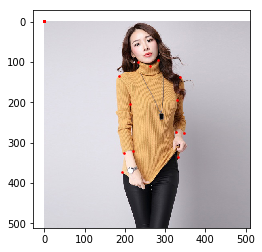

In [8]:
plt.figure()
show_landmarks(io.imread(os.path.join(train_one_dir, train_one_img_name)),
               train_one_img_landmarks)
plt.show()

In [9]:
class ClothLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        img_kind = self.landmarks_frame.iloc[idx,1]

        landmarks = self.landmarks_frame.iloc[idx,2:]
        point_data = pd.Series(splitUnderline(landmarks))
        landmarks = point_data.as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 3)
        sample = {'image': image, 'landmarks': landmarks,'img_kind':img_kind}
        
        if self.transform:
            sample = self.transform(sample)

        return sample

0 (512, 512, 3) (24, 3)


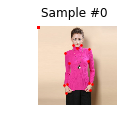

1 (512, 512, 3) (24, 3)


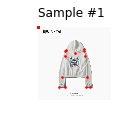

2 (512, 512, 3) (24, 3)


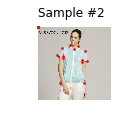

3 (512, 342, 3) (24, 3)


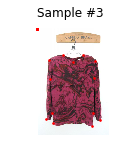

In [10]:
cloth_dataset = ClothLandmarksDataset(csv_file=train_one_dir+'train.csv',
                                    root_dir=train_one_dir)

fig = plt.figure()

for i in range(len(cloth_dataset)):
    sample = cloth_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(image=sample['image'],landmarks=sample['landmarks'])

    if i == 3:
        plt.show()
        break

In [11]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        # 本来只有h w 但是这里还有v *1代表 v值不变
        for i in landmarks:
            if i[2] == -1.0000:
                i = i
            else:
                i[0] = i[0] * (new_w / w)
                i[1] = i[1] * (new_h / h)
                i[2] = i[2]
#         landmarks = landmarks * [new_w / w, new_h / h,1]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]
        
        for i in landmarks:
            if i[2] == -1.0000:
                i = i
            else:
                i[0] = i[0] - left
                i[1] = i[1] - top
                i[2] = i[2]

#         landmarks = landmarks - [left, top,0]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}
    
class Normal(object):
    def __call__(self, sample):    
        imagenet_mean = np.array([0.485, 0.456, 0.406])
        imagenet_std  = np.array([0.229, 0.224, 0.225])
        image, landmarks = sample['image'], sample['landmarks']
        image = (image-imagenet_mean)/imagenet_std
        return {'image': image, 'landmarks': landmarks}

def denormalize(image, mean=imagenet_mean, std=imagenet_std):
    inp = image.transpose((1, 2, 0))
    img = std * inp + mean
    return img

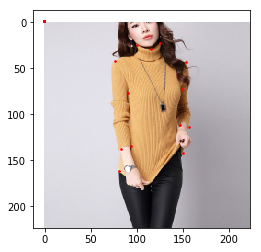

In [12]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])


cloth_dataset = ClothLandmarksDataset(csv_file=train_one_dir+'hebing.csv',
                                            root_dir=train_one_dir, 
                                            transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
#                                                Normal()
                                           ]))


# Apply each of the above transforms on sample.
fig = plt.figure()
sample = cloth_dataset[65]
plt.tight_layout()
show_landmarks(**sample)
#     print(transformed_sample['landmarks'])

plt.show()

In [13]:


transformed_dataset = ClothLandmarksDataset(csv_file=train_one_dir+'hebing.csv',
                                            root_dir=train_one_dir, 
                                            transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
#                                                Normal(),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())
    print(sample['landmarks'])

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([24, 3])
tensor([[ 93.5000,  50.5000,   1.0000],
        [120.0000,  48.5000,   1.0000],
        [107.0000,  59.0000,   1.0000],
        [ 67.5000,  75.0000,   1.0000],
        [147.5000,  64.0000,   1.0000],
        [ 79.5000, 108.0000,   1.0000],
        [143.0000, 103.0000,   1.0000],
        [ -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000],
        [ 74.0000, 177.0000,   1.0000],
        [ 64.0000, 181.5000,   1.0000],
        [146.0000, 175.5000,   1.0000],
        [156.0000, 178.5000,   1.0000],
        [ 70.5000, 206.0000,   0.0000],
        [149.5000, 198.5000,   0.0000],
        [ -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 24, 3])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 24, 3])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 24, 3])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 24, 3])


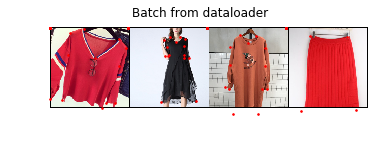

In [14]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

# 以下是训练的部分

In [15]:
use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: True


In [16]:
dsets = {
    'train': ClothLandmarksDataset(csv_file=train_one_dir+'hebing.csv',
                                            root_dir=train_one_dir, 
                                            transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
#                                                Normal(),
                                               ToTensor()
                                           ])),
    'valid': ClothLandmarksDataset(csv_file=train_one_dir+'hebing.csv',
                                            root_dir=train_one_dir, 
                                            transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
#                                                Normal(),
                                               ToTensor()
                                           ])),
    'test':  ClothLandmarksDataset(csv_file=test_dir+'test.csv',
                                            root_dir=test_dir, 
                                            transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
#                                                Normal(),
                                               ToTensor()
                                           ]))
}

In [17]:
batch_size = 4
random_seed = 3
valid_size = 0.2
shuffle = True

In [18]:
num_train = len(dsets['train'])
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

if shuffle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

sampler = {'train': train_sampler,
          'valid': valid_sampler,
          'test': None}

In [19]:
def create_dataLoader(dsets, batch_size, sampler={'train': None, 'valid': None,'test': None},
                      pin_memory=False):
  
    dset_loaders = {} 
    for key in dsets.keys():
        if sampler[key] != None:
            dset_loaders[key] = DataLoader(dsets[key], batch_size=batch_size, sampler=sampler[key], pin_memory=pin_memory)
        else:          
            dset_loaders[key] = DataLoader(dsets[key], batch_size=batch_size, pin_memory=pin_memory, shuffle=False)

    return dset_loaders

In [20]:
dset_loaders = create_dataLoader(dsets, batch_size, sampler, pin_memory=False)

In [21]:
sample = next(iter(dset_loaders['train']))
print(sample['image'].size(), sample['landmarks'].size())

torch.Size([4, 3, 224, 224]) torch.Size([4, 24, 3])


In [22]:
nb_out = 72
print('Number of outputs: {}'.format(nb_out))

Number of outputs: 72


In [23]:
class MobileNet(nn.Module):
    def __init__(self):
        super(MobileNet, self).__init__()

        def conv_bn(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True)
            )

        def conv_dw(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
                nn.BatchNorm2d(inp),
                nn.ReLU(inplace=True),
    
                nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True),
            )

        self.model = nn.Sequential(
            conv_bn(  3,  32, 2), 
            conv_dw( 32,  64, 1),
            conv_dw( 64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),
            nn.AvgPool2d(7),
        )
        self.fc = nn.Linear(1024, nb_out)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

In [24]:
model = MobileNet()

if use_gpu:
    model.cuda() 

In [25]:
print(model)

MobileNet(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias

In [26]:
def evaluate_model(loader, model, loss_fn, use_gpu = False):
    
    total_loss = 0
    for i, ( inputs, labels) in enumerate(loader):     
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
                
        # forward pass
        outputs = model(inputs)
        
        # loss
        loss = loss_fn(outputs, labels)
        
        # metrics
        total_loss += loss.data[0]
            
    return (total_loss / i)

In [27]:
def train(model, train_loader, test_loader ,num_epochs, loss_fn, optimizer, patience  ):
    
    loss_train = []
    loss_test = []
    best_test_acc =  np.inf
    
    patience_count= 0
    ii_n = len(train_loader)
    for epoch in range(num_epochs):
        for i, sample_batched in enumerate(train_loader):
            print('\rpredict: {}/{}'.format(i, ii_n - 1), end='')
            if use_gpu:
                inputs, labels = Variable(sample_batched['image'].type(torch.FloatTensor).cuda()), Variable(sample_batched['landmarks'].type(torch.FloatTensor).reshape(-1,72).cuda())
            else:
                inputs, labels = Variable(sample_batched['image']), Variable(sample_batched['landmarks'])
            predict = model(inputs)
            
            
            loss = loss_fn(predict, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        loss_train.append(loss.data[0])
#         loss_test.append( evaluate_model(test_loader, model,loss_fn, use_gpu) )
        
#         print('\nEpoch: {}  Loss Train: {}  Lost Test: {}'.format(epoch, loss_train[-1], loss_test[-1]), end='\n')
        print('\nEpoch: {}  Loss Train: {} '.format(epoch, loss_train[-1]), end='\n')
        
        #Early stopping
        if(best_test_acc > loss_train[-1]):
            patience_count = 0
            best_test_acc = loss_train[-1]
            best_model = copy.deepcopy(model)

        if(patience_count > patience):
            break;

        patience_count += 1
        
        
    print('\rDone!')
    torch.save(model, './model2')
    print('save_done! at ./model2 ')
    return loss_train, model 

In [28]:
loss_fn = torch.nn.MSELoss()
optimizer =  optim.RMSprop(model.parameters(), lr=1e-3)
num_epochs = 1
patience = 2

In [29]:
params = {'model' : model, 
        'train_loader':dset_loaders['train'],
         'test_loader':None,
         'num_epochs': num_epochs,
         'loss_fn': loss_fn,
         'optimizer': optimizer, 
         'patience': patience 
         }

In [30]:
loss_train, model = train(**params)

predict: 15373/15373
Epoch: 0  Loss Train: 1964.8177490234375 
Done!
save_done! at ./model2 
